<a href="https://colab.research.google.com/github/petegordon/AlpacaAPI/blob/main/LSTM_SPY_Direction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#!pip install tensorflow

# 1. First, make sure your imports are correct
# Data manipulation
import numpy as np
import pandas as pd

# Machine learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt

In [22]:

from datetime import time

def build_lstm_dataset(df, features, lookback_days=6, cutoff_time=time(12, 0), expected_bars_per_day=390, current_day_bars_cutoff=30):
    """
    Build dataset for LSTM model with both price and direction targets

    Args:
        df: DataFrame with bar data
        features: List of feature column names
        lookback_days: Number of days to look back for the sequence
        cutoff_time: Latest time of day to include for prediction
        expected_bars_per_day: Expected number of bars per trading day
        current_day_bars_cutoff: Max number of bars to use from current day

    Returns:
        X: Features array with shape (n_samples, timesteps, n_features)
        y_price: Price targets with shape (n_samples,)
        y_direction: One-hot encoded direction targets with shape (n_samples, n_classes)
        direction_categories: List of direction category labels
        date_labels: List of dates corresponding to each sample
    """
    df = df.sort_values("bar_ts").copy()
    df = df.dropna(subset=features + ['close_at_4pm', 'direction'])
    trade_dates = sorted(df["trade_date"].unique())

    sequence_length = lookback_days * expected_bars_per_day + current_day_bars_cutoff

    X, y_price, y_direction, date_labels = [], [], [], []

    for i in range(lookback_days, len(trade_dates) - 1):
        past_dates = trade_dates[i - lookback_days:i]
        target_date = trade_dates[i]

        past_data = df[df["trade_date"].isin(past_dates)]

        # Fix: Ensure trade_time is properly handled
        # First, check if trade_time is already a time object
        if isinstance(df['trade_time'].iloc[0], time):
            # If it's already a time object, we need to compare differently
            current_data = df[
                (df["trade_date"] == target_date) &
                (df["trade_time"] <= cutoff_time)
            ]
        else:
            # If it's a string or datetime, convert as needed
            # Try to convert to datetime first if it's a string
            try:
                if isinstance(df['trade_time'].iloc[0], str):
                    df['trade_time'] = pd.to_datetime(df['trade_time']).dt.time
                    current_data = df[
                        (df["trade_date"] == target_date) &
                        (df["trade_time"] <= cutoff_time)
                    ]
                elif pd.api.types.is_datetime64_any_dtype(df['trade_time']):
                    # It's already a datetime column
                    current_data = df[
                        (df["trade_date"] == target_date) &
                        (df["trade_time"].dt.time <= cutoff_time)
                    ]
                else:
                    # If none of the above, use a more general comparison
                    # Convert the cutoff time to a string for comparison
                    cutoff_str = cutoff_time.strftime('%H:%M:%S')
                    current_data = df[
                        (df["trade_date"] == target_date) &
                        (df["trade_time"].astype(str) <= cutoff_str)
                    ]
            except Exception as e:
                print(f"Error processing trade_time: {e}")
                print(f"trade_time type: {type(df['trade_time'].iloc[0])}")
                print(f"trade_time sample: {df['trade_time'].iloc[0]}")
                # Fallback: just use the date without time filtering
                current_data = df[df["trade_date"] == target_date]

        sequence_df = pd.concat([past_data, current_data])
        features_only = sequence_df[features]

        if len(features_only) < sequence_length:
            # pad short sequences
            pad_len = sequence_length - len(features_only)
            padded = np.pad(features_only.to_numpy(), ((pad_len, 0), (0, 0)), mode="constant", constant_values=0)
        elif len(features_only) > sequence_length:
            # truncate long sequences
            padded = features_only.to_numpy()[-sequence_length:]
        else:
            padded = features_only.to_numpy()

        # Get 4pm close price (regression target)
        target_price = df[df["trade_date"] == target_date]["close_at_4pm"].iloc[0]

        # Get direction (classification target)
        # Use last bar of the day before cutoff time
        last_bar = current_data.iloc[-1] if len(current_data) > 0 else None

        if pd.isnull(target_price) or last_bar is None:
            continue

        target_direction = last_bar["direction"]

        X.append(padded)
        y_price.append(target_price)
        y_direction.append(target_direction)
        date_labels.append(target_date)

    # One-hot encode the direction labels
    encoder = OneHotEncoder(sparse=False)
    y_direction_encoded = encoder.fit_transform(np.array(y_direction).reshape(-1, 1))

    return np.array(X), np.array(y_price), y_direction_encoded, encoder.categories_[0], date_labels

def train_multitask_lstm(X, y_price, y_direction):
    """
    Train a multi-task LSTM to predict both price and direction
    """
    # Split the dataset - keep time order for time series data
    X_train, X_test, y_price_train, y_price_test, y_dir_train, y_dir_test = train_test_split(
        X, y_price, y_direction, shuffle=False, test_size=0.2
    )

    # Flatten for scaler, then reshape back
    num_samples_train, timesteps, num_features = X_train.shape
    scaler = StandardScaler()

    X_train_flat = X_train.reshape(-1, num_features)
    X_test_flat = X_test.reshape(-1, num_features)

    X_train_scaled = scaler.fit_transform(X_train_flat).reshape(num_samples_train, timesteps, num_features)
    X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape[0], timesteps, num_features)

    # Scale price targets
    price_scaler = StandardScaler()
    y_price_train_scaled = price_scaler.fit_transform(y_price_train.reshape(-1, 1)).flatten()
    y_price_test_scaled = price_scaler.transform(y_price_test.reshape(-1, 1)).flatten()

    # Build multi-task model
    inputs = tf.keras.Input(shape=(timesteps, num_features))
    lstm_out = LSTM(128, return_sequences=False)(inputs)
    lstm_out = Dropout(0.3)(lstm_out)
    shared_layer = Dense(64, activation='relu')(lstm_out)
    shared_layer = Dropout(0.2)(shared_layer)

    # Price prediction head
    price_output = Dense(1, name='price_output')(shared_layer)

    # Direction prediction head
    direction_output = Dense(y_direction.shape[1], activation='softmax', name='direction_output')(shared_layer)

    model = tf.keras.Model(inputs=inputs, outputs=[price_output, direction_output])

    model.compile(
        optimizer='adam',
        loss={
            'price_output': 'mse',
            'direction_output': 'categorical_crossentropy'
        },
        metrics={
            'price_output': 'mae',
            'direction_output': 'accuracy'
        }
    )

    model.summary()

    # Train the model
    history = model.fit(
        X_train_scaled,
        {'price_output': y_price_train_scaled, 'direction_output': y_dir_train},
        validation_split=0.1,
        epochs=50,
        batch_size=32,
        verbose=1
    )

    # Evaluate
    eval_results = model.evaluate(
        X_test_scaled,
        {'price_output': y_price_test_scaled, 'direction_output': y_dir_test},
        verbose=0
    )

    print(f"Test Results: {dict(zip(model.metrics_names, eval_results))}")

    # Make predictions
    price_pred_scaled, direction_pred = model.predict(X_test_scaled)

    # Inverse transform price predictions
    price_pred = price_scaler.inverse_transform(price_pred_scaled).flatten()

    # Convert direction probabilities to class indices
    direction_pred_classes = np.argmax(direction_pred, axis=1)
    direction_true_classes = np.argmax(y_dir_test, axis=1)

    # Generate classification report
    from sklearn.metrics import classification_report
    direction_categories = ["DOWN", "UNCHANGED", "UP"]
    print("\nDirection Classification Report:")
    print(classification_report(
        direction_true_classes,
        direction_pred_classes,
        target_names=direction_categories
    ))

    # Plot price predictions
    plt.figure(figsize=(12, 5))
    plt.plot(y_price_test, label="Actual 4pm Close")
    plt.plot(price_pred, label="Predicted")
    plt.title("SPY 4pm Close Prediction")
    plt.xlabel("Sample")
    plt.ylabel("Price")
    plt.legend()
    plt.savefig('spy_price_prediction.png')
    plt.show()

    # Plot confusion matrix for direction prediction
    cm = confusion_matrix(direction_true_classes, direction_pred_classes)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix: Direction Prediction')
    plt.colorbar()
    tick_marks = np.arange(len(direction_categories))
    plt.xticks(tick_marks, direction_categories, rotation=45)
    plt.yticks(tick_marks, direction_categories)

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Direction')
    plt.xlabel('Predicted Direction')
    plt.savefig('spy_direction_prediction_cm.png')
    plt.show()

    return model, scaler, price_scaler, direction_categories


def predict_with_model(model, X_new, feature_scaler, price_scaler, direction_categories):
    """
    Make predictions with the trained model on new data

    Args:
        model: Trained multi-task LSTM model
        X_new: New feature data with shape (n_samples, timesteps, n_features)
        feature_scaler: Fitted StandardScaler for features
        price_scaler: Fitted StandardScaler for price output
        direction_categories: List of direction categories

    Returns:
        price_predictions: Predicted 4pm close prices
        direction_predictions: Predicted directions (DOWN, UNCHANGED, UP)
        direction_probabilities: Probabilities for each direction class
    """
    # Flatten for scaling, then reshape back
    n_samples, timesteps, n_features = X_new.shape
    X_new_flat = X_new.reshape(-1, n_features)
    X_new_scaled = feature_scaler.transform(X_new_flat).reshape(n_samples, timesteps, n_features)

    # Predict
    price_pred_scaled, direction_probs = model.predict(X_new_scaled)

    # Inverse transform price predictions
    price_predictions = price_scaler.inverse_transform(price_pred_scaled).flatten()

    # Convert direction probabilities to class indices and then to class names
    direction_indices = np.argmax(direction_probs, axis=1)
    direction_predictions = [direction_categories[idx] for idx in direction_indices]

    return price_predictions, direction_predictions, direction_probs

In [23]:
# Step: Load the CSV into a DataFrame
file_path = './spy_bars_direction.csv'
df = pd.read_csv(file_path)

In [24]:
df

,id,open,high,low,close,volume,number_of_trades,bar_ts,trade_date,trade_time,...,relative_volume_30,minutes_since_open,bar_num,high_since_open,low_since_open,cumulative_volume,open_at_930am,close_at_4pm,close_pct_diff,direction
0,4bbe824c-254d-4fec-89ab-e4671d83dcc3,384.00,386.54,384.0000,386.51,26198,289,2023-01-03 09:00:00+00:00,2023-01-03,09:00:00,...,1.000000,-1.0,1,386.54,384.00,26198.0,386.68,382.04,-1.156503,DOWN
1,4bbe824c-254d-4fec-89ab-e4671d83dcc3,386.50,386.53,385.9100,385.96,50073,182,2023-01-03 09:05:00+00:00,2023-01-03,09:05:00,...,1.313029,-1.0,2,386.54,384.00,76271.0,386.68,382.04,-1.015649,DOWN
2,4bbe824c-254d-4fec-89ab-e4671d83dcc3,386.18,386.51,386.1300,386.51,7497,70,2023-01-03 09:10:00+00:00,2023-01-03,09:10:00,...,0.268492,-1.0,3,386.54,384.00,83768.0,386.68,382.04,-1.156503,DOWN
3,4bbe824c-254d-4fec-89ab-e4671d83dcc3,386.54,386.79,386.2800,386.28,8990,106,2023-01-03 09:15:00+00:00,2023-01-03,09:15:00,...,0.387675,-1.0,4,386.79,384.00,92758.0,386.68,382.04,-1.097649,DOWN
4,4bbe824c-254d-4fec-89ab-e4671d83dcc3,386.48,386.70,386.4800,386.70,3736,40,2023-01-03 09:20:00+00:00,2023-01-03,09:20:00,...,0.193587,-1.0,5,386.79,384.00,96494.0,386.68,382.04,-1.205069,DOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104046,65a28094-ee9c-4c45-b0ab-a86235b61df9,564.85,564.86,564.8300,564.85,949,52,2025-03-21 23:35:00+00:00,2025-03-21,23:35:00,...,0.159186,-1.0,187,565.10,558.03,83709865.0,561.90,559.44,-0.957776,DOWN
104047,65a28094-ee9c-4c45-b0ab-a86235b61df9,564.82,564.82,564.8000,564.80,3007,60,2025-03-21 23:40:00+00:00,2025-03-21,23:40:00,...,0.507302,-1.0,188,565.10,558.03,83712872.0,561.90,559.44,-0.949008,DOWN
104048,65a28094-ee9c-4c45-b0ab-a86235b61df9,564.80,564.85,564.7000,564.82,13235,84,2025-03-21 23:45:00+00:00,2025-03-21,23:45:00,...,2.276898,-1.0,189,565.10,558.03,83726107.0,561.90,559.44,-0.952516,DOWN
104049,65a28094-ee9c-4c45-b0ab-a86235b61df9,564.80,564.86,564.7604,564.86,1762,26,2025-03-21 23:50:00+00:00,2025-03-21,23:50:00,...,0.337089,-1.0,190,565.10,558.03,83727869.0,561.90,559.44,-0.959530,DOWN


In [25]:
# Define features to use
features = [
    "open", "high", "low", "close", "volume",
    "vwap", "momentum_5", "momentum_10", "stddev_10",
    "relative_volume_30", "minutes_since_open",
    "high_since_open", "low_since_open", "cumulative_volume",
    "open_at_930am"
]

# Call build_lstm_dataset with customized parameters
X, y_price, y_direction, direction_categories, dates = build_lstm_dataset(
    df=df,                           # Preprocessed dataframe
    features=features,               # List of feature column names
    lookback_days=6,                 # Use 6 days of history
    cutoff_time=time(12, 0),         # Predict using data up to noon
    expected_bars_per_day=390,       # Expected number of 1-min bars per day
    current_day_bars_cutoff=30       # Use first 30 bars of current day
)

print(f"Dataset built successfully:")
print(f"X shape: {X.shape}")
print(f"y_price shape: {y_price.shape}")
print(f"y_direction shape: {y_direction.shape}")
print(f"Direction categories: {direction_categories}")
print(f"Date range: {dates[0]} to {dates[-1]}")

C:\Users\Afiat_Trading\AppData\Local\Temp\ipykernel_57664\723497896.py:49: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['trade_time'] = pd.to_datetime(df['trade_time']).dt.time


Dataset built successfully:
X shape: (510, 2370, 15)
y_price shape: (510,)
y_direction shape: (510, 3)
Direction categories: ['DOWN' 'UNCHANGED' 'UP']
Date range: 2023-01-11 to 2025-03-20


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2370, 15)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │     73,728 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_output        │ (None, 1)         │         65 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ direction_output    │ (None, 3)         │        195 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 82,244 (321.27 KB)

 Trainable params: 82,244 (321.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 601ms/step - direction_output_accuracy: 0.3630 - direction_output_loss: 1.0962 - loss: 1.8552 - price_output_loss: 0.7580 - price_output_mae: 0.7510 - val_direction_output_accuracy: 0.3659 - val_direction_output_loss: 1.1006 - val_loss: 3.1381 - val_price_output_loss: 2.2786 - val_price_output_mae: 1.4189
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 678ms/step - direction_output_accuracy: 0.3960 - direction_output_loss: 1.0694 - loss: 1.5623 - price_output_loss: 0.4916 - price_output_mae: 0.5785 - val_direction_output_accuracy: 0.3659 - val_direction_output_loss: 1.1054 - val_loss: 2.3802 - val_price_output_loss: 1.3724 - val_price_output_mae: 1.1133
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 738ms/step - direction_output_accuracy: 0.3632 - direction_output_loss: 1.1155 - loss: 1.3637 - price_output_loss: 0.2483 - price_output_mae: 0.3934 - val_direction_output_accuracy: 0.3659 - val_direction_output_loss: 1.0828 - val_loss: 1.1736 - val_price_output_

c:\Users\Afiat_Trading\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  
c:\Users\Afiat_Trading\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  
c:\Users\Afiat_Trading\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


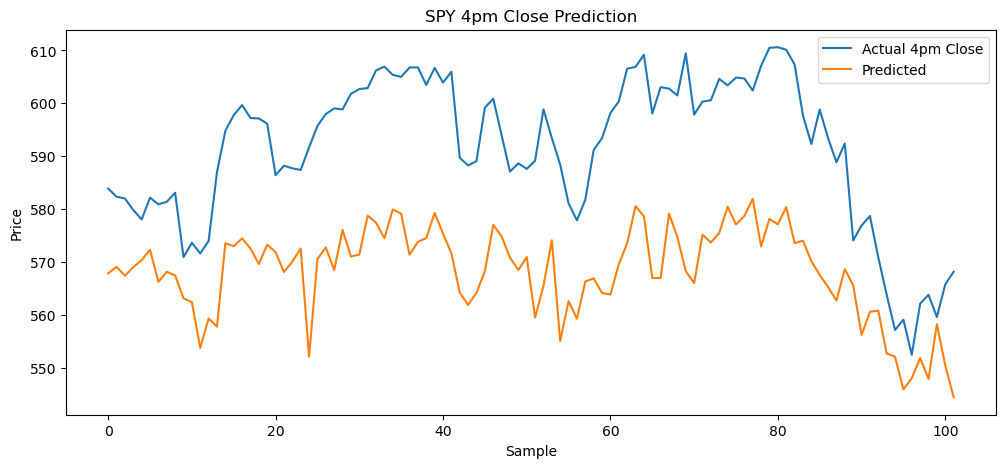

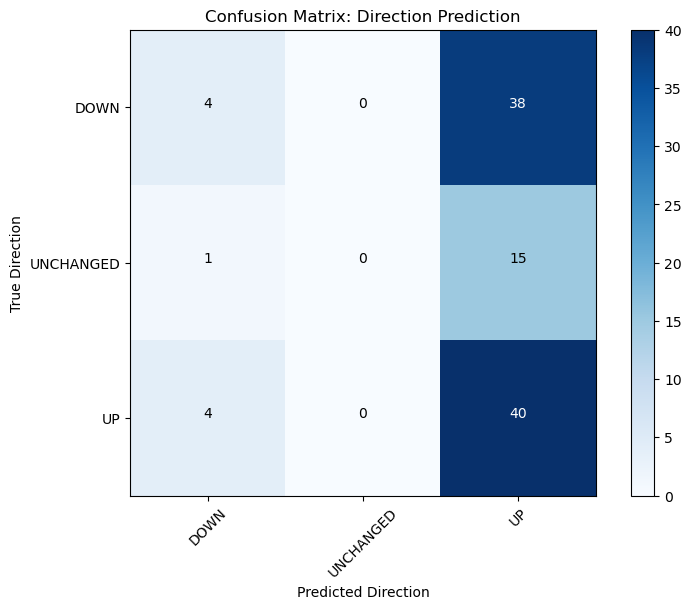

Model trained successfully


In [26]:
# Call train_multitask_lstm with the datasets
model, feature_scaler, price_scaler, direction_categories = train_multitask_lstm(
    X=X,                   # Features array with shape (n_samples, timesteps, n_features)
    y_price=y_price,       # Price targets with shape (n_samples,)
    y_direction=y_direction # One-hot encoded direction targets with shape (n_samples, n_classes)
)

print("Model trained successfully")

# Save the model and scalers for later use
#model.save('spy_multitask_model')

# For saving scalers, you would need to use pickle
#import pickle
#with open('feature_scaler.pkl', 'wb') as f:
#    pickle.dump(feature_scaler, f)
#with open('price_scaler.pkl', 'wb') as f:
#    pickle.dump(price_scaler, f)
#with open('direction_categories.pkl', 'wb') as f:
#    pickle.dump(direction_categories, f)

In [27]:

test_samples = X[-20:]  # Use last 5 samples

# Call predict_with_model
price_predictions, direction_predictions, direction_probabilities = predict_with_model(
    model=model,                           # Trained multi-task model
    X_new=test_samples,                    # New feature data
    feature_scaler=feature_scaler,         # Feature scaler used during training
    price_scaler=price_scaler,             # Price scaler used during training
    direction_categories=direction_categories  # Direction category labels
)

# Print predictions
print("\nPredictions:")
for i, (price, direction, probs) in enumerate(zip(price_predictions, direction_predictions, direction_probabilities)):
    print(f"Sample {i+1}:")
    print(f"  Predicted price: ${price:.2f}")
    print(f"  Direction: {direction}")
    print(f"  Probabilities: DOWN={probs[0]:.2f}, UNCHANGED={probs[1]:.2f}, UP={probs[2]:.2f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step

Predictions:
Sample 1:
  Predicted price: $573.58
  Direction: UP
  Probabilities: DOWN=0.16, UNCHANGED=0.29, UP=0.55
Sample 2:
  Predicted price: $574.05
  Direction: UP
  Probabilities: DOWN=0.20, UNCHANGED=0.23, UP=0.57
Sample 3:
  Predicted price: $570.15
  Direction: DOWN
  Probabilities: DOWN=0.64, UNCHANGED=0.03, UP=0.33
Sample 4:
  Predicted price: $567.56
  Direction: UP
  Probabilities: DOWN=0.15, UNCHANGED=0.25, UP=0.60
Sample 5:
  Predicted price: $565.29
  Direction: UP
  Probabilities: DOWN=0.26, UNCHANGED=0.18, UP=0.56
Sample 6:
  Predicted price: $562.73
  Direction: UP
  Probabilities: DOWN=0.18, UNCHANGED=0.24, UP=0.58
Sample 7:
  Predicted price: $568.67
  Direction: UP
  Probabilities: DOWN=0.32, UNCHANGED=0.13, UP=0.56
Sample 8:
  Predicted price: $565.60
  Direction: UP
  Probabilities: DOWN=0.19, UNCHANGED=0.25, UP=0.57
Sample 9:
  Predicted price: $556.23
  Direction: UP
  Probabilities: DOWN=0.11, UNCHANGED=0.29, UP=0.59
